In [8]:
# Load Larger LSTM network and generate text



import os
import numpy
import matplotlib.pyplot as plt
import pandas
import math
import numpy as np
import keras.callbacks
import sklearn.metrics as metrics
from pathlib import Path
from keras.models import Sequential
from keras.layers import Dense, Reshape
from keras.layers import LSTM,SimpleRNN, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.preprocessing.image import ImageDataGenerator

# Import function to plot the confussion matrix
import plotcm



In [2]:
#model_type = 'LSTM'
#model_type = 'GRU'
model_type = 'SIMPLE'
action = "train" 
#action = "test" 


data_path = "../DATA/BW-dogs-vs-cats/train/"
test_path = "../DATA/BW-dogs-vs-cats/test/"



learning_rate = 0.001
training_steps = 10000
timesteps = 28
batch_size = 64
shape_size = 200
num_hidden = 128
display_step = shape_size

experiment_rootdir = '../RNN-results/'
weights_path = experiment_rootdir + model_type + "_weights.h5"
accuracy_img_name = experiment_rootdir + model_type + '_accuracy-loss.png'
cm_dir = experiment_rootdir + model_type

# Output dimension (number of sublects in our problem)
num_classes = 2
# Name of each gesture of the database
CLASSES = ['cat', 'dog']

if not os.path.exists(experiment_rootdir):
    os.makedirs(experiment_rootdir)
if not os.path.exists(experiment_rootdir):
    os.makedirs(experiment_rootdir)

In [3]:
"""
count=0
for f_name in os.listdir(path_subjects):
    if(count<20):
        img = Image.open(path_subjects + '/' + f_name)
        plt.imshow(img, vmin=0, vmax=255)
        plt.title('subject: ' + str(f_name))
        plt.show()
        count+=1
"""

"\ncount=0\nfor f_name in os.listdir(path_subjects):\n    if(count<20):\n        img = Image.open(path_subjects + '/' + f_name)\n        plt.imshow(img, vmin=0, vmax=255)\n        plt.title('subject: ' + str(f_name))\n        plt.show()\n        count+=1\n"

In [4]:
# prepare iterators
datagen = ImageDataGenerator(rescale=1.0/255.0)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

train_it = datagen.flow_from_directory(data_path, class_mode='binary', color_mode = 'grayscale', batch_size=batch_size, target_size=(shape_size, shape_size))
test_it = datagen.flow_from_directory(test_path, class_mode='binary', color_mode = 'grayscale', batch_size=batch_size, target_size=(shape_size, shape_size))


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [5]:
def LSTM_Model():
    # create and fit the LSTM network
    model = Sequential()
    model.add(Reshape((200, 200), input_shape=(200, 200,1)))
    model.add(LSTM(4))
    model.add(Dense(1))

    model.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
    return model
    
def GRU_Model():
    # create and fit the LSTM network
    model = Sequential()
    model.add(Reshape((200, 200), input_shape=(200, 200,1)))
    model.add(GRU(4,return_sequences=False))
    model.add(Dense(1))

    model.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
    return model

def SIMPLE_Model():
    # create and fit the LSTM network
    model = Sequential()
    model.add(Reshape((200, 200), input_shape=(200, 200,1)))
    model.add(SimpleRNN(128))
    model.add(Dense(1))

    model.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
    return model


In [6]:

if model_type == 'LSTM':
    model = LSTM_Model()
elif model_type == 'GRU':
    model = GRU_Model()
elif model_type == 'SIMPLE':
    model = SIMPLE_Model()

if action == 'train':
    if  os.path.exists(weights_path):
        os.remove(weights_path)
    STEPS_PER_EPOCH_TRAIN = train_it.n//batch_size
    cb_checkpointer = keras.callbacks.ModelCheckpoint(filepath = weights_path, monitor = 'accuracy', save_best_only = True, mode = 'auto')
    fit_history = model.fit_generator(generator=train_it, epochs=10, steps_per_epoch=STEPS_PER_EPOCH_TRAIN, callbacks=[cb_checkpointer])
elif action == 'test':
    if weights_path:
        try:
            model.load_weights(weights_path)
            print("Loaded model from {}".format(weights_path))
        except:
            print("Impossible to find weight path. Returning untrained model")
    

Epoch 1/10
312/312 [==============================] - 135s 432ms/step - loss: 0.2638 - accuracy: 0.5370
Epoch 2/10
312/312 [==============================] - 99s 316ms/step - loss: 0.2495 - accuracy: 0.5491
Epoch 3/10
312/312 [==============================] - 95s 305ms/step - loss: 0.2475 - accuracy: 0.5535
Epoch 4/10
312/312 [==============================] - 113s 361ms/step - loss: 0.2456 - accuracy: 0.5629
Epoch 5/10
312/312 [==============================] - 110s 353ms/step - loss: 0.2449 - accuracy: 0.5696
Epoch 6/10
312/312 [==============================] - 95s 304ms/step - loss: 0.2446 - accuracy: 0.5693
Epoch 7/10
312/312 [==============================] - 92s 294ms/step - loss: 0.2431 - accuracy: 0.5769
Epoch 8/10
312/312 [==============================] - 85s 273ms/step - loss: 0.2429 - accuracy: 0.5774
Epoch 9/10
312/312 [==============================] - 84s 270ms/step - loss: 0.2442 - accuracy: 0.5690
Epoch 10/10
312/312 [==============================] - 87s 278ms/step 

(4992,)
-----------------------------------------------
Evaluation:
Average accuracy = 0.500801282051282
-----------------------------------------------


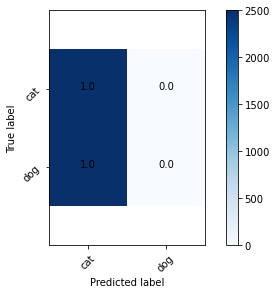

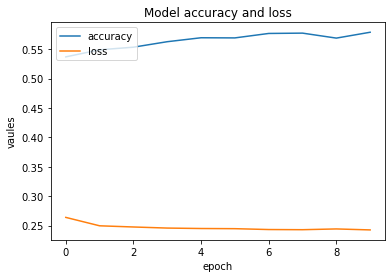

In [7]:
# Get predictions using predict_generator function
STEPS_PER_EPOCH_TEST = test_it.n//batch_size
pred_labels = model.predict_generator(test_it,steps = STEPS_PER_EPOCH_TEST)
pred_labels = np.argmax(pred_labels, axis = 1)

# Select the class which has the higher predicted value
print(pred_labels.shape)

# Create groundtruth
gt = np.zeros(pred_labels.shape)
init_index = 0
end_index = 0
user_id = 0
for users in sorted(os.listdir(test_path)):
    user_id = user_id + 1
    if os.path.isdir(os.path.join(test_path, users)):
        user_path = os.path.join(test_path, users)
        for root, _, files in sorted(os.walk(user_path)):
            num_images_user = len(files)
            end_index = init_index + num_images_user
            gt[init_index:end_index] = user_id - 1
            init_index = end_index
            
# Evaluate predictions: Average accuracy and highest errors
print("-----------------------------------------------")
print("Evaluation:")
# Compute average accuracy
ave_accuracy = metrics.accuracy_score(gt, pred_labels)
print('Average accuracy = ' + str(ave_accuracy))
print("-----------------------------------------------")

# Visualize confusion matrix
plotcm.plotcm(experiment_rootdir, gt, pred_labels,CLASSES, experiment_rootdir, normalize=True)

if action == 'train':
    plt.plot(fit_history.history['accuracy'])
    plt.plot(fit_history.history['loss'])
    plt.title('Model accuracy and loss')
    plt.ylabel('vaules')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'loss'], loc='upper left')
    # Save the figure
    plt.savefig(accuracy_img_name)
    # Show figure
    plt.show()

